In [2]:
# Import packages, the Y-matrix for the dataset and Functions.py
import numpy as np
%run Dolphins_data_import.ipynb
import sys
sys.path.append('../')
from Functions import * 
import copy
import random

In [3]:
num_samples = 62 
num_splits = 10
procent = 10
random_numbers_matrix = np.zeros((num_splits,int(len(Y)/100*procent)))
k = 0
s = 0
while k < num_splits:
    random_numbers = random.sample(range(0, len(Y)), int(len(Y)/100*procent))
    Y_updated = np.delete(Y, random_numbers, axis=0)
    s += 1
    degree = np.zeros(num_samples)
    for m in range(len(Y_updated)): 
        if Y_updated[m][0] == 1: 
            degree[int(Y_updated[m][1])-1] += 1
            degree[int(Y_updated[m][2])-1] += 1
    
    if not np.any(degree == 0) :
        random_numbers_matrix[k] = random_numbers
        k += 1

In [4]:
dim = 2

# Define mu and cov_matrix to be able to sample #num_samples samples from a multivariate normal distribution
mu = np.zeros(dim) 
identity_matrix = np.eye(dim) 
cov_matrix = identity_matrix 

points = {l+1: np.random.multivariate_normal(mu, cov_matrix) for l in range(num_samples)}

In [5]:
alpha = 5 # change alpha here
True_posetiv = np.zeros(len(random_numbers_matrix))
True_negativ = np.zeros(len(random_numbers_matrix))
False_posetiv = np.zeros(len(random_numbers_matrix))
False_negativ = np.zeros(len(random_numbers_matrix))


MLL_final = np.zeros(len(random_numbers_matrix)) # Define the MLL
grad_sum_final = np.zeros(len(random_numbers_matrix)) # Define the gradient sum

for s in range(len(random_numbers_matrix)):
    Y_updated = np.delete(Y, random_numbers_matrix[s].flatten().astype(int), axis=0)

    prev_grad = 200
    grad = 0
    n = 100000
    points_copy = copy.deepcopy(points)
    MLL = np.zeros(n) # Define the MLL
    grad_sum = np.zeros(n) # Define the gradient sum
    k = 0

    while abs(prev_grad - grad) > 0.01: # stopping criteria
        prev_grad = grad
        for i in range(1,num_samples+1): # Run over number of num_samples
            grad_now = Gradient_function_prior_fast(i,dim,Y_updated,points_copy,alpha)
            grad_sum[k] += np.sum((grad_now)**2)
            points_copy[i] += LR(k)*grad_now # Use Gradient_function and take step=0.1*grad
        grad = grad_sum[k]
        MLL[k] = Loss_function_prior_fast(points_copy,Y_updated,dim,alpha) # Calcualte the probability using Loss_function
        k += 1

    MLL_final[s] = MLL[k-1]
    grad_sum_final[s] = grad_sum[k-1]

    connections = Y[random_numbers, 0]
    point_a = [points_copy[i] for i in Y[random_numbers,1]]
    point_b = [points_copy[i] for i in Y[random_numbers,2]]
    points_a_np = np.array(point_a)
    points_b_np = np.array(point_b)


    distances = np.sum((points_a_np - points_b_np) ** 2, axis=1)
    sigmoid_value = 1 / (1 + np.exp(-connections * (alpha - distances)))

    True_posetiv[s] = np.sum(connections*sigmoid_value >= 0.5)
    False_posetiv[s] = np.sum(connections*sigmoid_value <= -0.5)
    True_negativ[s] = np.sum((connections*sigmoid_value > -0.5) & (connections*sigmoid_value < 0))
    False_negativ[s] = np.sum((connections*sigmoid_value >= 0) & (connections*sigmoid_value < 0.5))

In [6]:
conf_matrix = np.array([[np.mean(True_posetiv), np.mean(False_negativ)],
                        [np.mean(False_posetiv), np.mean(True_negativ)]])
Accuracy = (np.mean(True_posetiv)+np.mean((True_negativ)))/(len(sigmoid_value))

In [7]:
conf_matrix

array([[ 16.1,   2.9],
       [159.5,  10.5]])

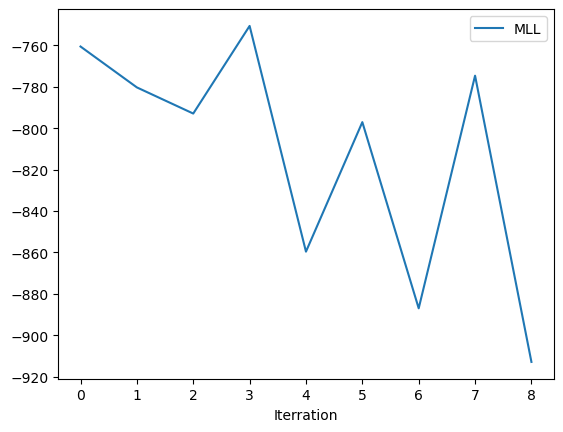

In [8]:
plt.plot(MLL_final[0:s],label='MLL')
#plt.plot(np.sqrt(grad_sum_final[0:s]), label='Gradient sum')
#plt.ylabel('MLL')
plt.xlabel('Iterration')
plt.legend()
plt.show()

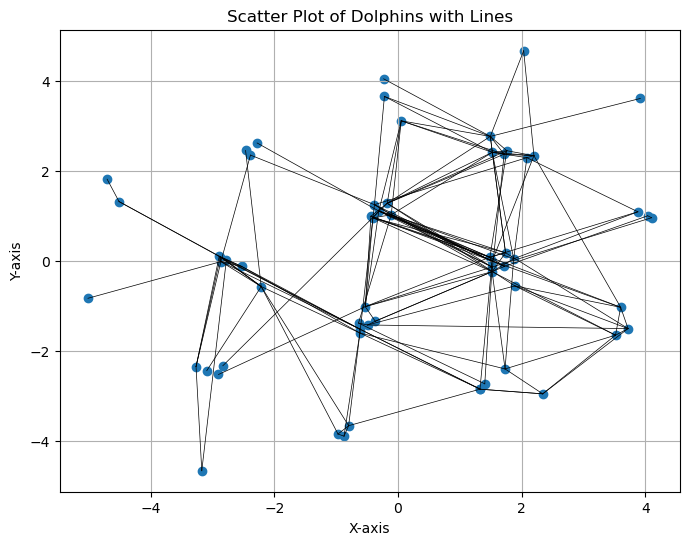

In [9]:
plt.figure(figsize=(8, 6))

for m in range(len(Y)): 
    if Y[m][0] == 1: # Check if there is a connection between Y[m][1] and Y[m][2]
        point1 = points_copy[Y[m][1]]
        point2 = points_copy[Y[m][2]]
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color='black', linewidth=0.5) # Ad a line between Y[m][1] and Y[m][2]

# extract the points and plot them
x = [point[0] for point in points_copy.values()]
y = [point[1] for point in points_copy.values()]
plt.scatter(x, y)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Dolphins with Lines')
plt.grid(True)
plt.show()